In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Dropout, 
                                      LSTM, TimeDistributed, Input)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import psutil

print("=" * 80)
print("🎬 LSTM VIOLENCE DETECTION - BASED ON 91% ACCURACY CODE")
print("=" * 80)

2025-11-12 21:35:28.245803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762983328.494148      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762983328.561414      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

🎬 LSTM VIOLENCE DETECTION - BASED ON 91% ACCURACY CODE


In [2]:
# ============================================================================
# LSTM VIDEO DATA GENERATOR
# ============================================================================
class LSTMVideoDataGenerator(tf.keras.utils.Sequence):
    """
    Data generator for LSTM model
    Returns sequences of frames instead of averaged frames
    """
    
    def __init__(self, video_paths, labels, batch_size=8, target_size=(160, 160), 
                 frames_per_video=10, augment=False, shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.frames_per_video = frames_per_video  # This is now sequence length
        self.augment = augment
        self.indexes = np.arange(len(self.video_paths))
        self.shuffle = shuffle
        
        # Data augmentation
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
                brightness_range=[0.8, 1.2],
                fill_mode='nearest'
            )
        
        print(f"LSTM Generator initialized with {len(self.video_paths)} videos")
        print(f"   Each video → sequence of {self.frames_per_video} frames")
        print(f"   Batch size: {self.batch_size}")
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Shape: (batch_size, sequence_length, height, width, channels)
        X = np.zeros((len(batch_indexes), self.frames_per_video, *self.target_size, 3), 
                     dtype=np.float32)
        y = np.zeros(len(batch_indexes), dtype=np.float32)
        
        for i, idx in enumerate(batch_indexes):
            frame_sequence = self.extract_frame_sequence(self.video_paths[idx])
            
            if frame_sequence is not None:
                if self.augment:
                    frame_sequence = self.apply_augmentation_to_sequence(frame_sequence)
                X[i] = frame_sequence
            
            y[i] = self.labels[idx]
            gc.collect()
        
        return X, y

    def extract_frame_sequence(self, video_path):
        """
        Extract a sequence of frames instead of averaging them
        Returns: numpy array of shape (frames_per_video, height, width, 3)
        """
        try:
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            if total_frames <= 0:
                cap.release()
                return None
            
            frames = []
            # Extract evenly spaced frames
            frame_indices = np.linspace(0, total_frames - 1, 
                                      min(self.frames_per_video, total_frames), 
                                      dtype=int)
            
            for frame_idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                
                if ret:
                    frame = cv2.resize(frame, self.target_size)
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = frame.astype(np.float32) / 255.0
                    frames.append(frame)
            
            cap.release()
            
            # Ensure we have exactly frames_per_video frames
            while len(frames) < self.frames_per_video:
                # Pad with black frames if video too short
                frames.append(np.zeros((*self.target_size, 3), dtype=np.float32))
            
            return np.array(frames[:self.frames_per_video])
            
        except Exception as e:
            print(f"Error processing video {video_path}: {str(e)}")
            return None

    def apply_augmentation_to_sequence(self, frame_sequence):
        """Apply augmentation to each frame in the sequence"""
        augmented_sequence = []
        
        for frame in frame_sequence:
            frame_uint8 = (frame * 255).astype(np.uint8)
            frame_expanded = np.expand_dims(frame_uint8, axis=0)
            augmented = self.datagen.flow(frame_expanded, batch_size=1).__next__()[0]
            augmented_sequence.append(augmented.astype(np.float32) / 255.0)
        
        return np.array(augmented_sequence)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [3]:
# ============================================================================
# LSTM MODEL WITH MOBILENETV2 FEATURE EXTRACTOR
# ============================================================================
def create_lstm_model(input_shape=(10, 160, 160, 3)):
    """
    Create LSTM model using MobileNetV2 as feature extractor
    
    Architecture:
    1. TimeDistributed MobileNetV2 - extracts features from each frame
    2. LSTM layers - capture temporal patterns
    3. Dense layers - final classification
    
    Args:
        input_shape: (sequence_length, height, width, channels)
    """
    
    print("\n🏗️  Building LSTM Model with MobileNetV2...")
    
    sequence_length, height, width, channels = input_shape
    
    # Input layer
    inputs = Input(shape=input_shape)
    
    # MobileNetV2 as feature extractor (frozen initially)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(height, width, channels)
    )
    base_model.trainable = False
    
    # Apply MobileNetV2 to each frame in the sequence
    x = TimeDistributed(base_model)(inputs)
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    
    # LSTM layers to capture temporal patterns
    x = LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(x)
    x = LSTM(64, dropout=0.3, recurrent_dropout=0.2)(x)
    
    # Dense layers (same as original model)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=predictions)
    
    return model, base_model

In [4]:
# ============================================================================
# DATASET LOADING
# ============================================================================
def load_dataset(violence_path, nonviolence_path):
    """Load video paths and labels"""
    
    violence_videos = [os.path.join(violence_path, f) for f in os.listdir(violence_path) 
                      if f.endswith(('.mp4', '.avi', '.mov'))]
    nonviolence_videos = [os.path.join(nonviolence_path, f) for f in os.listdir(nonviolence_path) 
                         if f.endswith(('.mp4', '.avi', '.mov'))]
    
    all_videos = violence_videos + nonviolence_videos
    labels = [1] * len(violence_videos) + [0] * len(nonviolence_videos)
    
    print(f"\n📊 Dataset Summary:")
    print(f"   Total videos: {len(all_videos)}")
    print(f"   Violence videos: {len(violence_videos)}")
    print(f"   Non-violence videos: {len(nonviolence_videos)}")
    
    # Split dataset
    X_temp, X_test, y_temp, y_test = train_test_split(
        all_videos, labels, test_size=0.15, stratify=labels, random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42
    )
    
    print(f"\n   Training videos: {len(X_train)}")
    print(f"   Validation videos: {len(X_val)}")
    print(f"   Test videos: {len(X_test)}")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [5]:
# ============================================================================
# PLOTTING
# ============================================================================
def plot_training_history(history):
    """Plot training history"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('LSTM Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('LSTM Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('lstm_training_history.png', dpi=200, bbox_inches='tight')
    print("📊 Training history saved as 'lstm_training_history.png'")
    plt.show()

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    """Plot confusion matrix"""
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Violence', 'Violence'],
                yticklabels=['Non-Violence', 'Violence'])
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('lstm_confusion_matrix.png', dpi=200, bbox_inches='tight')
    print("📊 Confusion matrix saved as 'lstm_confusion_matrix.png'")
    plt.show()

In [6]:
# ============================================================================
# MAIN TRAINING FUNCTION
# ============================================================================
def main():
    """Main training function"""
    
    # Configuration
    VIOLENCE_PATH = '/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence'
    NON_VIOLENCE_PATH = '/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence'
    
    BATCH_SIZE = 8  # Smaller for LSTM (uses more memory)
    TARGET_SIZE = (160, 160)
    FRAMES_PER_VIDEO = 10  # Sequence length for LSTM
    EPOCHS_PHASE1 = 8
    EPOCHS_PHASE2 = 8
    
    print(f"\n⚙️  Configuration:")
    print(f"   Image size: {TARGET_SIZE}")
    print(f"   Sequence length: {FRAMES_PER_VIDEO} frames")
    print(f"   Batch size: {BATCH_SIZE}")
    
    # Load dataset
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_dataset(
        VIOLENCE_PATH, NON_VIOLENCE_PATH
    )
    
    # Create data generators
    print("\n🔄 Creating data generators...")
    train_generator = LSTMVideoDataGenerator(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        target_size=TARGET_SIZE,
        frames_per_video=FRAMES_PER_VIDEO,
        augment=True,
        shuffle=True
    )
    
    val_generator = LSTMVideoDataGenerator(
        X_val, y_val,
        batch_size=BATCH_SIZE,
        target_size=TARGET_SIZE,
        frames_per_video=FRAMES_PER_VIDEO,
        augment=False,
        shuffle=False
    )
    
    test_generator = LSTMVideoDataGenerator(
        X_test, y_test,
        batch_size=BATCH_SIZE,
        target_size=TARGET_SIZE,
        frames_per_video=FRAMES_PER_VIDEO,
        augment=False,
        shuffle=False
    )
    
    # Create model
    model, base_model = create_lstm_model(
        input_shape=(FRAMES_PER_VIDEO, *TARGET_SIZE, 3)
    )
    
    print("\n📋 Model Summary:")
    model.summary()
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            'best_lstm_model_phase1.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # ========================================================================
    # PHASE 1: Train with frozen MobileNetV2
    # ========================================================================
    
    print("\n" + "=" * 80)
    print("=== PHASE 1: Training with frozen MobileNetV2 ===")
    print("=" * 80)
    
    history_phase1 = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS_PHASE1,
        callbacks=callbacks,
        verbose=1
    )
    
    # ========================================================================
    # PHASE 2: Fine-tuning with unfrozen layers
    # ========================================================================
    
    print("\n" + "=" * 80)
    print("=== PHASE 2: Fine-tuning with unfrozen layers ===")
    print("=" * 80)
    
    # Unfreeze the last 30 layers of MobileNetV2
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    print(f"   Trainable layers: {sum(l.trainable for l in base_model.layers)}/{len(base_model.layers)}")
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks[1] = ModelCheckpoint(
        'best_lstm_model_final.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    history_phase2 = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS_PHASE2,
        callbacks=callbacks,
        verbose=1
    )
    
    # ========================================================================
    # EVALUATION
    # ========================================================================
    
    print("\n" + "=" * 80)
    print("📊 EVALUATING MODEL ON TEST SET")
    print("=" * 80)
    
    # Load best model
    model = tf.keras.models.load_model('best_lstm_model_final.keras')
    
    # Make predictions
    print("\nGenerating predictions...")
    y_pred_proba = model.predict(test_generator, verbose=1)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    y_true = y_test
    
    # Classification report
    print("\n📋 Classification Report:")
    print(classification_report(
        y_true, y_pred,
        target_names=['Non-Violence', 'Violence'],
        digits=4
    ))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\n📊 Confusion Matrix:")
    print(cm)
    
    # Plot results
    plot_training_history(history_phase2)
    plot_confusion_matrix(cm, title='LSTM Model - Confusion Matrix')
    
    # Calculate metrics
    accuracy = np.mean(y_pred == y_true)
    
    print("\n" + "=" * 80)
    print("✅ TRAINING COMPLETE!")
    print("=" * 80)
    print(f"📊 Final Test Accuracy: {accuracy*100:.2f}%")
    print(f"\n💾 Model saved as 'best_lstm_model_final.keras'")
    print(f"\n💡 LSTM Advantages:")
    print(f"   ✓ Captures temporal patterns (motion over time)")
    print(f"   ✓ Understands sequence of events")
    print(f"   ✓ Better context than single-frame or averaged frames")
    print(f"\n🎯 Comparison:")
    print(f"   Original (frame averaging): 91% accuracy")
    print(f"   LSTM (temporal patterns): {accuracy*100:.2f}% accuracy")
    print("=" * 80)
    
    return model, history_phase1, history_phase2

In [7]:
# ============================================================================
# PREDICTION FUNCTION
# ============================================================================
def predict_video(model, video_path, target_size=(160, 160), frames_per_video=10):
    """
    Predict violence in a new video using LSTM model
    """
    
    try:
        # Extract frame sequence
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames <= 0:
            print("❌ Could not read video")
            return None
        
        frames = []
        frame_indices = np.linspace(0, total_frames - 1, 
                                   min(frames_per_video, total_frames), 
                                   dtype=int)
        
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            
            if ret:
                frame = cv2.resize(frame, target_size)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = frame.astype(np.float32) / 255.0
                frames.append(frame)
        
        cap.release()
        
        # Pad if needed
        while len(frames) < frames_per_video:
            frames.append(np.zeros((*target_size, 3), dtype=np.float32))
        
        # Prepare for prediction
        sequence = np.array(frames[:frames_per_video])
        sequence = np.expand_dims(sequence, axis=0)  # Add batch dimension
        
        # Predict
        probability = model.predict(sequence, verbose=0)[0][0]
        prediction = "Violence" if probability >= 0.5 else "Non-Violence"
        
        print(f"\n🎬 Video: {os.path.basename(video_path)}")
        print(f"   Violence probability: {probability:.4f}")
        print(f"   Prediction: {prediction}")
        
        return probability, prediction
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None


🚀 Starting LSTM Violence Detection Training...
   Based on code that achieved 91% accuracy
   Now using LSTM for temporal pattern recognition


⚙️  Configuration:
   Image size: (160, 160)
   Sequence length: 10 frames
   Batch size: 8

📊 Dataset Summary:
   Total videos: 2000
   Violence videos: 1000
   Non-violence videos: 1000

   Training videos: 1400
   Validation videos: 300
   Test videos: 300

🔄 Creating data generators...
LSTM Generator initialized with 1400 videos
   Each video → sequence of 10 frames
   Batch size: 8
LSTM Generator initialized with 300 videos
   Each video → sequence of 10 frames
   Batch size: 8
LSTM Generator initialized with 300 videos
   Each video → sequence of 10 frames
   Batch size: 8

🏗️  Building LSTM Model with MobileNetV2...


2025-11-12 21:35:49.867880: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

📋 Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 160, 160,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 5, 5, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,078,465 (11.74 MB)

 Trainable params: 820,481 (3.13 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


=== PHASE 1: Training with frozen MobileNetV2 ===


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
125/175 ━━━━━━━━━━━━━━━━━━━━ 6:51 8s/step - accuracy: 0.6672 - loss: 0.5852

[h264 @ 0x7e8939b6bd00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8939b6bd00] error while decoding MB 98 31
[h264 @ 0x7e8939b6bd00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8939b6bd00] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7002 - loss: 0.5470
Epoch 1: val_accuracy improved from -inf to 0.91333, saving model to best_lstm_model_phase1.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 1842s 10s/step - accuracy: 0.7007 - loss: 0.5463 - val_accuracy: 0.9133 - val_loss: 0.2164 - learning_rate: 0.0010
Epoch 2/8
126/175 ━━━━━━━━━━━━━━━━━━━━ 6:58 9s/step - accuracy: 0.8917 - loss: 0.2809

[h264 @ 0x7e89440b1b40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89440b1b40] error while decoding MB 98 31
[h264 @ 0x7e89440b1b40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89440b1b40] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8932 - loss: 0.2750
Epoch 2: val_accuracy improved from 0.91333 to 0.93667, saving model to best_lstm_model_phase1.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 1803s 10s/step - accuracy: 0.8932 - loss: 0.2749 - val_accuracy: 0.9367 - val_loss: 0.2088 - learning_rate: 0.0010
Epoch 3/8
114/175 ━━━━━━━━━━━━━━━━━━━━ 8:26 8s/step - accuracy: 0.9327 - loss: 0.1900

[h264 @ 0x7e892803ad80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e892803ad80] error while decoding MB 98 31
[h264 @ 0x7e892803ad80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e892803ad80] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9285 - loss: 0.1953
Epoch 3: val_accuracy did not improve from 0.93667
175/175 ━━━━━━━━━━━━━━━━━━━━ 1783s 10s/step - accuracy: 0.9284 - loss: 0.1954 - val_accuracy: 0.9333 - val_loss: 0.1898 - learning_rate: 0.0010
Epoch 4/8
164/175 ━━━━━━━━━━━━━━━━━━━━ 1:33 8s/step - accuracy: 0.9406 - loss: 0.1725

[h264 @ 0x7e894c267c00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e894c267c00] error while decoding MB 98 31
[h264 @ 0x7e894c267c00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e894c267c00] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9407 - loss: 0.1731
Epoch 4: val_accuracy improved from 0.93667 to 0.94000, saving model to best_lstm_model_phase1.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 1793s 10s/step - accuracy: 0.9407 - loss: 0.1731 - val_accuracy: 0.9400 - val_loss: 0.1686 - learning_rate: 0.0010
Epoch 5/8
  6/175 ━━━━━━━━━━━━━━━━━━━━ 20:08 7s/step - accuracy: 1.0000 - loss: 0.0395

[h264 @ 0x7e89340a4f00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89340a4f00] error while decoding MB 98 31
[h264 @ 0x7e89340a4f00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89340a4f00] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9556 - loss: 0.1311
Epoch 5: val_accuracy improved from 0.94000 to 0.95000, saving model to best_lstm_model_phase1.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 1786s 10s/step - accuracy: 0.9555 - loss: 0.1311 - val_accuracy: 0.9500 - val_loss: 0.1705 - learning_rate: 0.0010
Epoch 6/8
 88/175 ━━━━━━━━━━━━━━━━━━━━ 12:14 8s/step - accuracy: 0.9509 - loss: 0.1362

[h264 @ 0x7e8929850f00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8929850f00] error while decoding MB 98 31
[h264 @ 0x7e8929850f00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8929850f00] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9506 - loss: 0.1392
Epoch 6: val_accuracy did not improve from 0.95000
175/175 ━━━━━━━━━━━━━━━━━━━━ 1795s 10s/step - accuracy: 0.9506 - loss: 0.1392 - val_accuracy: 0.8900 - val_loss: 0.2859 - learning_rate: 0.0010
Epoch 7/8
135/175 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - accuracy: 0.9472 - loss: 0.1450

[h264 @ 0x7e8a019a5440] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8a019a5440] error while decoding MB 98 31
[h264 @ 0x7e8a019a5440] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8a019a5440] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9473 - loss: 0.1449
Epoch 7: val_accuracy improved from 0.95000 to 0.95333, saving model to best_lstm_model_phase1.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 1796s 10s/step - accuracy: 0.9473 - loss: 0.1449 - val_accuracy: 0.9533 - val_loss: 0.1615 - learning_rate: 0.0010
Epoch 8/8
 62/175 ━━━━━━━━━━━━━━━━━━━━ 15:51 8s/step - accuracy: 0.9494 - loss: 0.1089

[h264 @ 0x7e89541c1600] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89541c1600] error while decoding MB 98 31
[h264 @ 0x7e89541c1600] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89541c1600] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9529 - loss: 0.1093
Epoch 8: val_accuracy did not improve from 0.95333
175/175 ━━━━━━━━━━━━━━━━━━━━ 1820s 10s/step - accuracy: 0.9529 - loss: 0.1093 - val_accuracy: 0.9400 - val_loss: 0.1774 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 7.

=== PHASE 2: Fine-tuning with unfrozen layers ===
   Trainable layers: 30/154
Epoch 1/8
  5/175 ━━━━━━━━━━━━━━━━━━━━ 30:19 11s/step - accuracy: 0.5796 - loss: 2.2893

[h264 @ 0x7e89340e7800] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89340e7800] error while decoding MB 98 31
[h264 @ 0x7e89340e7800] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89340e7800] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8377 - loss: 0.6098 
Epoch 1: val_accuracy improved from -inf to 0.95000, saving model to best_lstm_model_final.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 2587s 14s/step - accuracy: 0.8379 - loss: 0.6085 - val_accuracy: 0.9500 - val_loss: 0.1513 - learning_rate: 1.0000e-04
Epoch 2/8
 95/175 ━━━━━━━━━━━━━━━━━━━━ 15:44 12s/step - accuracy: 0.9266 - loss: 0.1872

[h264 @ 0x7e8a0d8099c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8a0d8099c0] error while decoding MB 98 31
[h264 @ 0x7e8a0d8099c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8a0d8099c0] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9258 - loss: 0.1898 
Epoch 2: val_accuracy improved from 0.95000 to 0.96333, saving model to best_lstm_model_final.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 2547s 15s/step - accuracy: 0.9258 - loss: 0.1899 - val_accuracy: 0.9633 - val_loss: 0.1213 - learning_rate: 1.0000e-04
Epoch 3/8
 37/175 ━━━━━━━━━━━━━━━━━━━━ 28:27 12s/step - accuracy: 0.9300 - loss: 0.1756

[h264 @ 0x7e89199c7fc0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89199c7fc0] error while decoding MB 98 31
[h264 @ 0x7e89199c7fc0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89199c7fc0] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9413 - loss: 0.1556 
Epoch 3: val_accuracy did not improve from 0.96333
175/175 ━━━━━━━━━━━━━━━━━━━━ 2533s 14s/step - accuracy: 0.9413 - loss: 0.1556 - val_accuracy: 0.9600 - val_loss: 0.1185 - learning_rate: 1.0000e-04
Epoch 4/8
 69/175 ━━━━━━━━━━━━━━━━━━━━ 21:38 12s/step - accuracy: 0.9742 - loss: 0.0849

[h264 @ 0x7e8945716700] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8945716700] error while decoding MB 98 31
[h264 @ 0x7e8945716700] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8945716700] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9681 - loss: 0.0986 
Epoch 4: val_accuracy improved from 0.96333 to 0.96667, saving model to best_lstm_model_final.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 2579s 15s/step - accuracy: 0.9680 - loss: 0.0987 - val_accuracy: 0.9667 - val_loss: 0.1218 - learning_rate: 1.0000e-04
Epoch 5/8
 93/175 ━━━━━━━━━━━━━━━━━━━━ 16:49 12s/step - accuracy: 0.9503 - loss: 0.0989

[h264 @ 0x7e8935c41140] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8935c41140] error while decoding MB 98 31
[h264 @ 0x7e8935c41140] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8935c41140] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9501 - loss: 0.1052 
Epoch 5: val_accuracy did not improve from 0.96667
175/175 ━━━━━━━━━━━━━━━━━━━━ 2567s 15s/step - accuracy: 0.9500 - loss: 0.1052 - val_accuracy: 0.9567 - val_loss: 0.1442 - learning_rate: 1.0000e-04
Epoch 6/8
 46/175 ━━━━━━━━━━━━━━━━━━━━ 26:01 12s/step - accuracy: 0.9545 - loss: 0.1340

[h264 @ 0x7e892801d0c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e892801d0c0] error while decoding MB 98 31
[h264 @ 0x7e892801d0c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e892801d0c0] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9565 - loss: 0.1198 
Epoch 6: val_accuracy improved from 0.96667 to 0.97000, saving model to best_lstm_model_final.keras

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
175/175 ━━━━━━━━━━━━━━━━━━━━ 2545s 15s/step - accuracy: 0.9565 - loss: 0.1197 - val_accuracy: 0.9700 - val_loss: 0.1367 - learning_rate: 1.0000e-04
Epoch 7/8
105/175 ━━━━━━━━━━━━━━━━━━━━ 14:09 12s/step - accuracy: 0.9877 - loss: 0.0669

[h264 @ 0x7e8909fcf8c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8909fcf8c0] error while decoding MB 98 31
[h264 @ 0x7e8909fcf8c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e8909fcf8c0] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9829 - loss: 0.0682 
Epoch 7: val_accuracy improved from 0.97000 to 0.97667, saving model to best_lstm_model_final.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 2544s 15s/step - accuracy: 0.9828 - loss: 0.0682 - val_accuracy: 0.9767 - val_loss: 0.1260 - learning_rate: 5.0000e-05
Epoch 8/8
120/175 ━━━━━━━━━━━━━━━━━━━━ 11:06 12s/step - accuracy: 0.9800 - loss: 0.0597

[h264 @ 0x7e89543203c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89543203c0] error while decoding MB 98 31
[h264 @ 0x7e89543203c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7e89543203c0] error while decoding MB 98 31


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9792 - loss: 0.0612 
Epoch 8: val_accuracy did not improve from 0.97667
175/175 ━━━━━━━━━━━━━━━━━━━━ 2557s 15s/step - accuracy: 0.9791 - loss: 0.0613 - val_accuracy: 0.9733 - val_loss: 0.1333 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 7.

📊 EVALUATING MODEL ON TEST SET

Generating predictions...
38/38 ━━━━━━━━━━━━━━━━━━━━ 469s 12s/step

📋 Classification Report:
              precision    recall  f1-score   support

Non-Violence     0.9605    0.9733    0.9669       150
    Violence     0.9730    0.9600    0.9664       150

    accuracy                         0.9667       300
   macro avg     0.9667    0.9667    0.9667       300
weighted avg     0.9667    0.9667    0.9667       300


📊 Confusion Matrix:
[[146   4]
 [  6 144]]
📊 Training history saved as 'lstm_training_history.png'


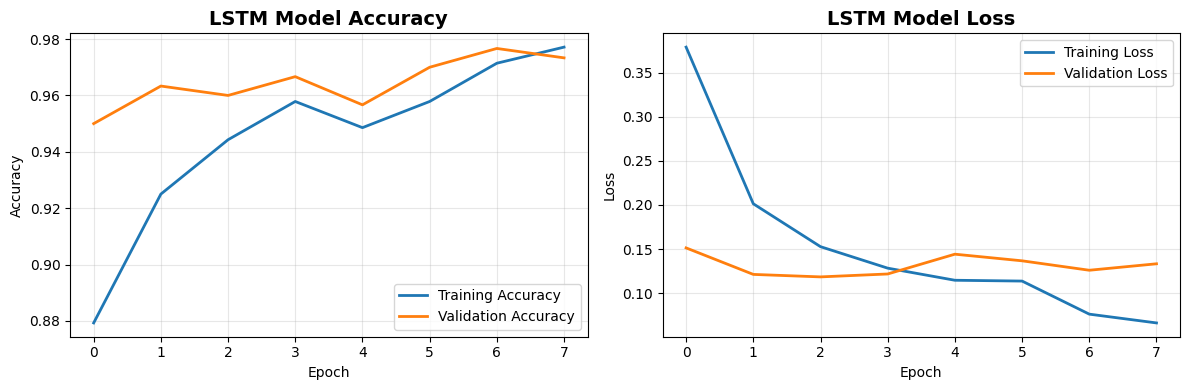

📊 Confusion matrix saved as 'lstm_confusion_matrix.png'


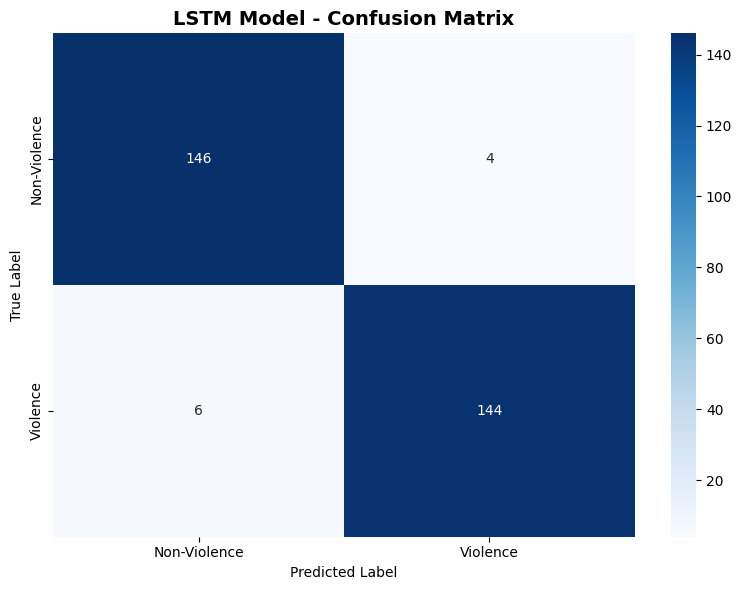


✅ TRAINING COMPLETE!
📊 Final Test Accuracy: 96.67%

💾 Model saved as 'best_lstm_model_final.keras'

💡 LSTM Advantages:
   ✓ Captures temporal patterns (motion over time)
   ✓ Understands sequence of events
   ✓ Better context than single-frame or averaged frames

🎯 Comparison:
   Original (frame averaging): 91% accuracy
   LSTM (temporal patterns): 96.67% accuracy

🎉 All done!

💡 To use the model on a new video:
   probability, prediction = predict_video(model, 'path/to/video.mp4')


In [8]:
# ============================================================================
# RUN
# ============================================================================
if __name__ == "__main__":
    try:
        print("\n🚀 Starting LSTM Violence Detection Training...")
        print("   Based on code that achieved 91% accuracy")
        print("   Now using LSTM for temporal pattern recognition\n")
        
        model, history_phase1, history_phase2 = main()
        
        print("\n🎉 All done!")
        print("\n💡 To use the model on a new video:")
        print("   probability, prediction = predict_video(model, 'path/to/video.mp4')")
        
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()